__This is a reproduction of "[Santos, F. C., Pacheco, J. M., & Lenaerts, T. (2006). Evolutionary dynamics of social dilemmas in structured heterogeneous populations](https://doi.org/10.1073/pnas.0508201103)".__

In [1]:
using Agents
using LightGraphs, GraphPlot
using Statistics: mean
using DataFrames: DataFrame
using Random: shuffle
using CSV
using Plots
using Test: @test

In [2]:
println("Julia $VERSION")

Julia 1.6.2


In [3]:
# スレッド数が6のとき最速
Threads.nthreads()

6

# 1. Define agent

In [4]:
const C = true
const D = false

mutable struct Player <: AbstractAgent
    id::Int
    pos::Int
    strategy::Bool # C or D
    next_strategy::Bool # C or D
    payoff::Float32 # 6 digits
end

function Player(id::Int, strategy::Bool)
    Player(id, id, strategy, D, Float32(0))
end

function Player(strategy::Bool)
    Player(-1, strategy)
end

function Player(id::Int, c_rate::Float64)
    Player(id, id, rand() < c_rate, D, Float32(0))
end

# Test
@test Player(C) isa Player
@test Player(1, D) isa Player
@test Player(1, 0.5) isa Player

Test Passed

# 2. Define pay-off table

We shall model interactions among individuals in terms of two-person games in which both players can either cooperate (C) or defect (D) when interacting with each other.

||C|D|
|:-:|:-:|:-:|
|C|R = 1|S|
|D|T|P = 0|

|Game|Abbr.|Parameters|
|:-:|:-:|:-:|
|Snowdrift|SG|T > 1 > S > 0|
|Stag Hunt|SH|1 > T > 0 > S|
|Prisoner's Dilemma|PD|T > 1 > 0 > S|

We study the behavior of all dilemmas, summarized in these tables, in the ranges 0 ≤ T ≤ 2 and −1 ≤ S ≤ 1, which will be shown to be sufficient to characterize the games under study.

In [5]:
struct PayOffTable
    R::Float32
    S::Float32
    T::Float32
    P::Float32
    
    PayOffTable(T::Float64, S::Float64) = new(Float32(1), Float32(S), Float32(T), Float32(0))
end

function play(payofftable::PayOffTable, me::Player, you::Player)::Float32
    if me.strategy && you.strategy
        payofftable.R
    elseif me.strategy && !you.strategy
        payofftable.S
    elseif !me.strategy && you.strategy
        payofftable.T
    elseif !me.strategy && !you.strategy
        payofftable.P
    end
end

# Test
payofftable = PayOffTable(1.5, -1.0)
@test play(payofftable, Player(C), Player(C)) == 1
@test play(payofftable, Player(C), Player(D)) == -1
@test play(payofftable, Player(D), Player(C)) == 1.5
@test play(payofftable, Player(D), Player(D)) == 0

Test Passed

# 3. Define a function for building network

- well mixed populations of size N are represented by complete graphs, which correspond to a regular, homogeneous graph with average connectivity z = N − 1, because all vertices share the same number of connections and are topologically equivalent.
- even when graphs are generated stochastically, as is the case for the Barabási–Albert NoC, the evolution of cooperation is studied in full-grown graphs; that is, the topology of the graph remains frozen throughout evolution.

In [6]:
function build_network(network_type::Symbol, N::Int = 104, k::Int = 4)
    if network_type == :complete
        complete_graph(N)
    elseif network_type == :single_scale
        SimpleGraph(N, N * k)
    elseif network_type == :scale_free_random
        G = barabasi_albert(N, k)
        
        for _ in 1:1000
            e1, e2 = get_random_edge_pair(G)
            G = rewire_edge_pair(G, e1, e2)
        end

        return G

    elseif network_type == :scale_free_ba
        barabasi_albert(N, k)
    end
end

function get_random_edge_pair(G::SimpleGraph)::Tuple{LightGraphs.SimpleGraphs.SimpleEdge, LightGraphs.SimpleGraphs.SimpleEdge}
    edge1 = first(shuffle(collect(edges(G))))
    
    while true
        edge2 = first(shuffle(collect(edges(G))))
        is_separated_edges = src(edge1) ≠ src(edge2) && src(edge1) ≠ dst(edge2) && dst(edge1) ≠ src(edge2) && dst(edge1) ≠ dst(edge2)
        is_separated_edges = is_separated_edges && !has_edge(G, src(edge1), dst(edge2)) && !has_edge(G, src(edge2), dst(edge1))
        if is_separated_edges
            return edge1, edge2
        end
    end
end

function rewire_edge_pair(G::SimpleGraph, edge1::LightGraphs.SimpleGraphs.SimpleEdge, edge2::LightGraphs.SimpleGraphs.SimpleEdge)
    rem_edge!(G, src(edge1), dst(edge1))
    rem_edge!(G, src(edge2), dst(edge2))
    add_edge!(G, src(edge1), dst(edge2))
    add_edge!(G, src(edge2), dst(edge1))
    G
end

rewire_edge_pair (generic function with 1 method)

### Complete Graph

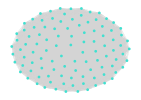

Test Passed

In [7]:
G = build_network(:complete)
display(gplot(G))
@test degree_histogram(G) == Dict(103 => 104)

### Single Scale Network

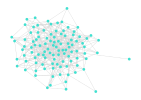

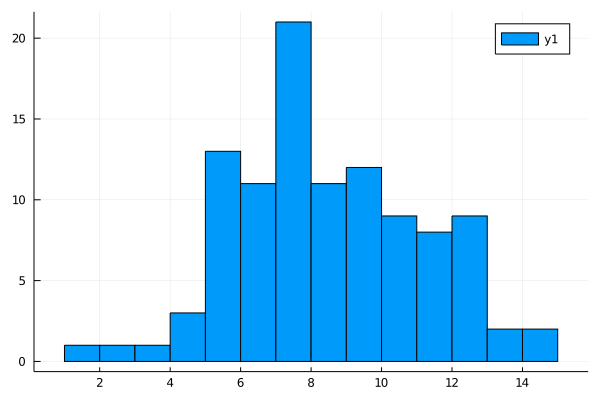

In [8]:
G = build_network(:single_scale)
display(gplot(G))
histogram(degree(G), nbins = 16, fmt = :png)

### Randamized Scale Free Network

- constructed by randomly reshuffling links, while keeping the in- and out-degree of each node constant.
- A convenient numerical algorithm performing such randomization consists of first randomly selecting a pair of directed edges A→B and C→D.
- The two edges are then rewired in such a way that A becomes connected to D, while C connects to B.
- However, in case one or both of these new links already exist in the network, this step is aborted and a new pair of edges is selected.

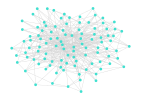

ne(G) / nv(G) = 3.8461538461538463


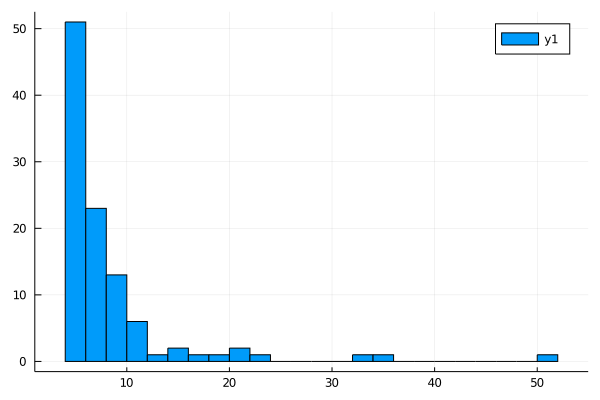

In [9]:
G = build_network(:scale_free_random)
display(gplot(G))
@show ne(G) / nv(G)
histogram(degree(G), fmt = :png)

### Scale Free Network (BA Model)

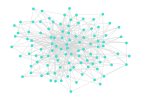

ne(G) / nv(G) = 3.8461538461538463


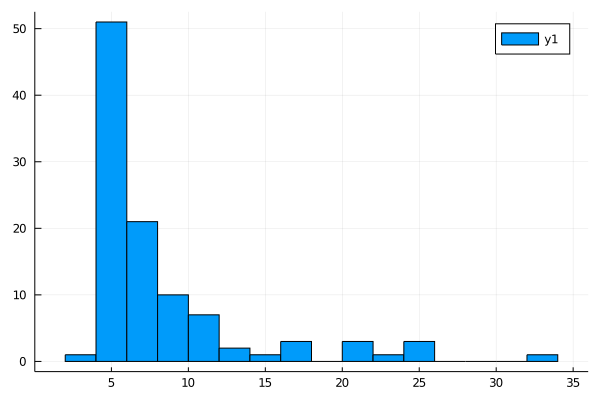

In [10]:
G = build_network(:scale_free_ba)
display(gplot(G))
@show ne(G) / nv(G)
histogram(degree(G), fmt = :png)

# 4. Define a function for building model

In [11]:
function build_model(;G::SimpleGraph, payofftable::PayOffTable, c_rate::Float64)
    space = GraphSpace(G)
    model = ABM(Player, space, properties = Dict(:payofftable => payofftable))

    # モデル上にエージェントを配置する。
    for id in 1:nv(G)
        add_agent_pos!(Player(id, c_rate), model)
    end

    return model
end

# Test
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable(1.5, -1.0), c_rate = 0.8)
@test length(allagents(model)) == 104
@test model.properties[:payofftable].T == 1.5

Test Passed

# 5. Define model behavior of 1step

In [12]:
function model_step!(model::AgentBasedModel)
    payofftable = model.properties[:payofftable]
    
    # In each life cycle (one generation), all pairs of directly connected individuals x and y engage in a single round of the game,
    # their accumulated payoff being stored as Px and Py, respectively.
    for agent in allagents(model)
        agent.payoff = 0f0
        for neighbor in nearby_agents(agent, model)
            agent.payoff += play(payofftable, agent, neighbor)
        end
    end
    
    # decide next strategy by pay-off
    for agent in allagents(model)
        # When a site x is updated, a neighbor y is drawn at random among all kx neighbors
        neighbors = nearby_agents(agent, model)
        length(neighbors) == 0 && continue
        neighbor = collect(neighbors)[rand(1:end)]
        
        # only if Py > Px the strategy of chosen neighbor y replaces that of x
        # with probability given by (Py - Px) / [k> D>],
        # where k> = max(kx, ky) and D> = max(T, 1) - min(S, 0).
        Px = agent.payoff
        Py = neighbor.payoff
        kx = length(neighbors)
        ky = length(nearby_agents(neighbor, model))
        k = max(kx, ky)
        D = max(payofftable.T, 1) - min(payofftable.S, 0)
        take_over_ratio = (Py - Px) / (k * D)
        
        if Py > Px && take_over_ratio > rand()
            agent.next_strategy = neighbor.strategy
        else
            agent.next_strategy = agent.strategy
        end
    end
    
    # update strategy
    for agent in allagents(model)
        agent.strategy = agent.next_strategy
    end
end

# Test
model = build_model(G = build_network(:single_scale, 100, 1), payofftable = PayOffTable(1.5, -1.0), c_rate = 0.5)
run!(model, dummystep, model_step!, 1; adata = [(:strategy, mean)])

model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable(1.5, -1.0), c_rate = 0.5)
@time run!(model, dummystep, model_step!, 1; adata = [(:strategy, mean)])
@time run!(model, dummystep, model_step!, 100; adata = [(:strategy, mean)])
@time run!(model, dummystep, model_step!, 10000; adata = [(:strategy, mean)])

@time Threads.@threads for _ in 1:10
    run!(model, dummystep, model_step!, 10000; adata = [(:strategy, mean)], when = 9001:10001)
end

"""
4 threads で以下の結果がでる。2 threads にするとパフォーマンスが落ちる。8 threads にすると結果が帰って来ない。1 thread では単純にループ数倍の時間がかかる。
 14.060641 seconds (451.42 M allocations: 25.285 GiB, 22.88% gc time, 0.25% compilation time)
5 threads
  8.760949 seconds (451.43 M allocations: 24.733 GiB, 12.38% gc time, 0.48% compilation time)
6 threads で以下の結果がでる。(最速)
  0.097120 seconds (123.30 k allocations: 7.230 MiB, 98.99% compilation time)
  0.030680 seconds (452.56 k allocations: 25.191 MiB)
  3.287348 seconds (45.22 M allocations: 2.460 GiB, 7.43% gc time)
  8.632726 seconds (451.44 M allocations: 24.583 GiB, 12.25% gc time, 0.46% compilation time)
7 threads
  9.047743 seconds (451.45 M allocations: 24.706 GiB, 11.76% gc time, 0.46% compilation time)
"""

nothing

  0.000450 seconds (4.65 k allocations: 267.375 KiB)
  0.049405 seconds (452.64 k allocations: 25.346 MiB, 38.26% gc time)
  3.307820 seconds (45.22 M allocations: 2.475 GiB, 8.16% gc time)
  9.372843 seconds (453.32 M allocations: 24.841 GiB, 12.09% gc time, 5.64% compilation time)


# 6. Execute simulation

- Simulations were carried out on graphs with N = __104__ vertices and average connectivity z = __4__ (except in Fig. 2 Left, where z = N - 1).
- Equilibrium frequencies of cooperators and defectors were obtained for each value of T and S by averaging over 1,000 generations after a transient time of 10,000 generations (we confirmed that averaging over larger periods or using different transient times did not change the results).
- Furthermore, final data results from averaging over 100 simulations, corresponding to 10 runs for each of 10 different realizations of a given type of NoC specified by the appropriate parameters (N and z).
- All simulations start with an equal percentage of strategies (cooperators and defectors) randomly distributed among the elements of the population.
- In this way, all vertices are initially populated with a strategy, and no initial advantage is given to cooperators or to defectors.

In [13]:
function run_simulation(payofftable::PayOffTable, network_type::Symbol)::Float64
    N_gen = 11000
    f_c = 0

    for _ in 1:10
        G = build_network(network_type)
        
        @time Threads.@threads for _ in 1:10
            model = build_model(;G, payofftable, c_rate = 0.5)
            temp_df, _ = run!(model, dummystep, model_step!, N_gen; adata = [(:strategy, mean)], when = (N_gen - 999):(N_gen + 1))
            f_c += mean(temp_df.mean_strategy)
        end
    end
    
    return f_c / 100
end

run_simulation (generic function with 1 method)

In [14]:
df = DataFrame(network_type = Symbol[], T = Float64[], S = Float64[], f_c = Float64[])

,network_type,T,S,f_c
,Symbol,Float64,Float64,Float64


In [ ]:
for network_type in [:complete, :single_scale, :scale_free_random, :scale_free_ba]
    for T in 0.0:0.25:2.0
        for S in -1.0:0.25:1.0
            println("$(network_type): T = $(T), S = $(S)")
            @time push!(df, [network_type, T, S, run_simulation(PayOffTable(T, S), network_type)])
        end
    end
end

In [ ]:
@show Set(df.network_type)
@show size(df)
CSV.write("out/result.csv", df)

# 6. Result

In [19]:
df = CSV.read("out/result.csv", DataFrame)
df.network_type = [Symbol(x) for x in df.network_type]
@show Set(df.network_type)
@show size(df)

Set(df.network_type) = Set([:single_scale, :scale_free_random, :scale_free_ba, :complete])
size(df) = (324, 4)


(324, 4)

In [20]:
function draw_heatmap(df::DataFrame, network_type::Symbol)::Plots.Plot
    x = 0.0:0.25:2.0
    y = -1.0:0.25:1.0
    z = Array{Float64}(undef, length(x), length(y))
    
    for (x_i, x_value) in enumerate(x)
        for (y_i, y_value) in enumerate(y)
            df[(df.network_type .== network_type) .& (df.T .== x_value) .& (df.S .== y_value), :f_c]
            z[y_i, x_i] = df[(df.network_type .== network_type) .& (df.T .== x_value) .& (df.S .== y_value), :f_c][1]
        end
    end
    
    heatmap(["$s" for s in x], ["$s" for s in y], z, c = cgrad([:black, :blue, :green, :yellow, :orange, :red]), fmt = :png, title = network_type)
end

draw_heatmap (generic function with 1 method)

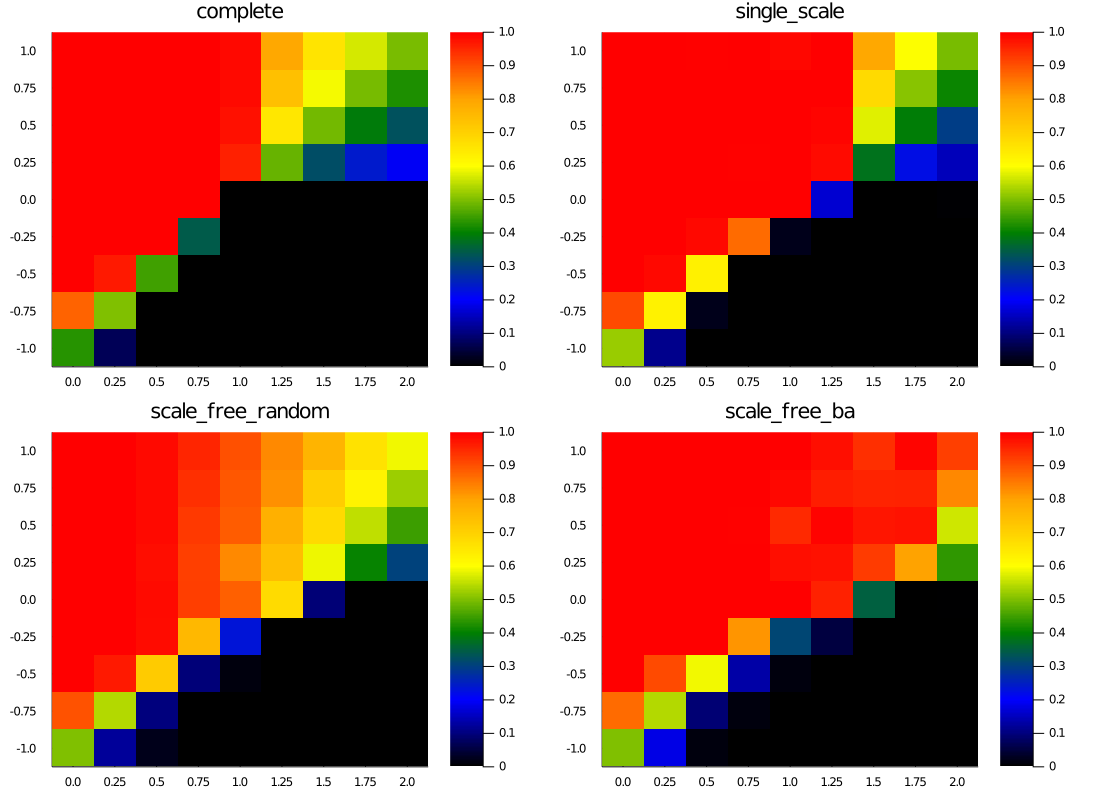

In [21]:
ps = [draw_heatmap(df, network_type) for network_type in (:complete, :single_scale, :scale_free_random, :scale_free_ba)]
plot(ps..., size = (1100, 800))